In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

Data loaded. Valid households (completed interviews): 12949
Generating Standard Graphs for eastern...
Generating Handwashing Graph (Figure 3)...
All eastern graphs created successfully.


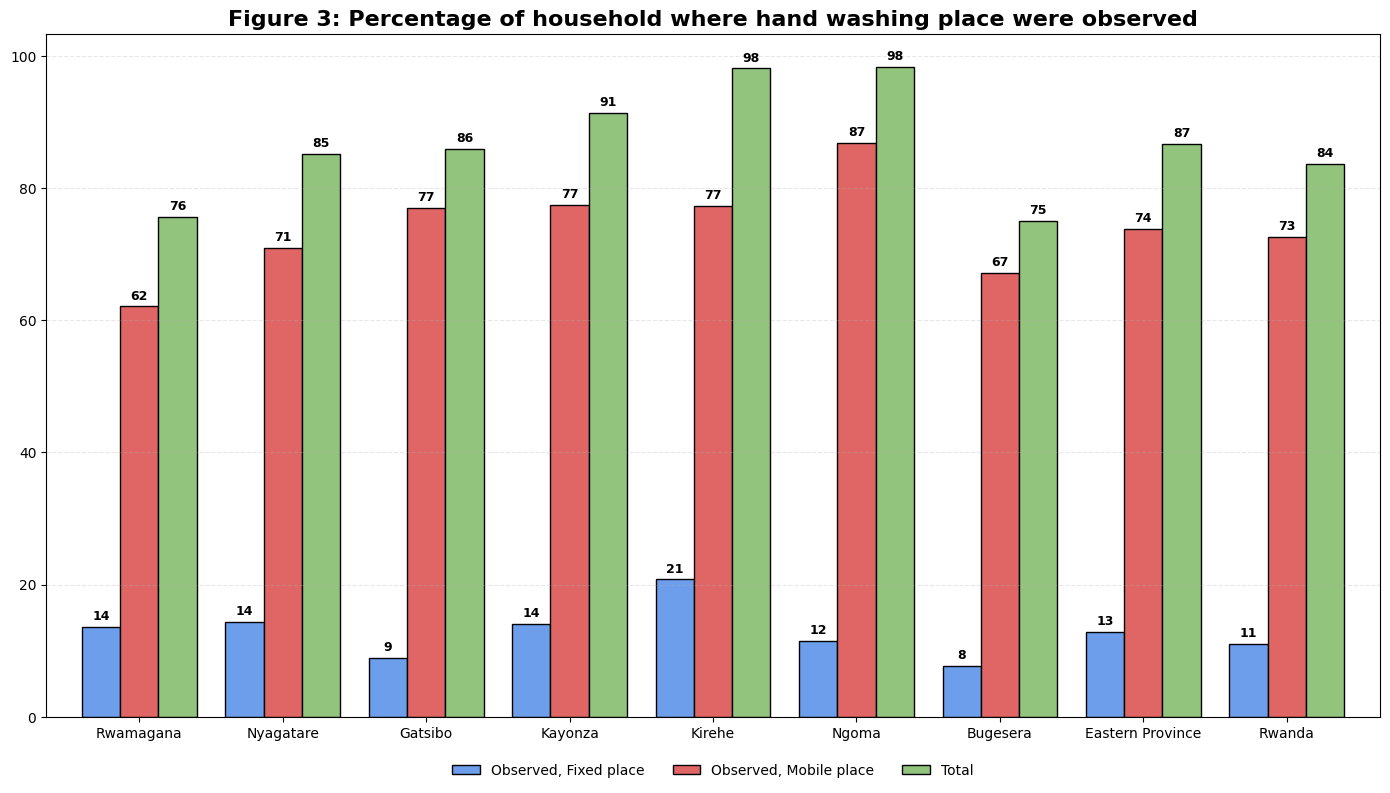

In [2]:
# --- STEP 1: Load & Global Filter ---
# Load data
df_hr = pd.read_stata("../data/RWHR81FL.DTA", convert_categoricals=False)
df_hr.columns = df_hr.columns.str.lower()

# *** CRITICAL FIX: Filter for COMPLETED Interviews ***
df_hr = df_hr[df_hr['hv015'] == 1].copy()
print(f"Data loaded. Valid households (completed interviews): {len(df_hr)}")

# --- STEP 2: Logic Definition ---

# A. Standard Indicators
binary_vars = {
    'has_electricity': 'hv206',
    'has_mobile': 'hv243a',
    'has_radio': 'hv207',
    'has_tv': 'hv208',
    'has_computer': 'hv243e'
}

for new_col, old_col in binary_vars.items():
    # 1->1, 0->0, 9/Missing -> NaN
    df_hr[new_col] = df_hr[old_col].replace({9: np.nan})

# B. Handwashing Indicators (Figure 3 Logic)
# 1=Fixed, 2=Mobile
df_hr['hw_fixed'] = np.where(df_hr['hv230a'] == 1, 1, 0)
df_hr['hw_mobile'] = np.where(df_hr['hv230a'] == 2, 1, 0)
df_hr['hw_total'] = df_hr['hv230a'].isin([1, 2]).astype(int)

# --- STEP 3: The "Safe" Math Function ---
def get_weighted_pct(df, target_col, weight_col='hv005'):
    # We must ensure the weight column exists before dropping NaNs
    temp = df[[target_col, weight_col]].dropna()
    if len(temp) == 0: return 0
    return np.average(temp[target_col], weights=temp[weight_col]) * 100

# --- STEP 4: Setup eastern CITY ---
EASTERN_REGION_CODE = 5
df_hr_eastern = df_hr[df_hr['hv024'] == EASTERN_REGION_CODE].copy()

# The Map for eastern Districts
district_map = {
    51: 'Rwamagana', 
    52: 'Nyagatare', 
    53: 'Gatsibo',
    54: 'Kayonza',
    55: 'Kirehe',
    56: 'Ngoma',
    57: 'Bugesera'
}

# ==========================================
# PART 1: STANDARD GRAPHS (Electricity etc.)
# ==========================================
indicators = ['has_electricity', 'has_mobile', 'has_radio', 'has_tv', 'has_computer']
titles = {'has_electricity': 'Electricity Access', 'has_mobile': 'Mobile Phone', 
          'has_radio': 'Radio', 'has_tv': 'Television', 'has_computer': 'Computer'}

print("Generating Standard Graphs for eastern...")

for col in indicators:
    # Calculate District
    dist_vals = df_hr_eastern.groupby('shdistrict').apply(lambda x: get_weighted_pct(x, col)).round(1)
    dist_vals.index = dist_vals.index.map(district_map)
    
    # Calculate Province (eastern City Total) & National
    prov_val = get_weighted_pct(df_hr_eastern, col)
    nat_val = get_weighted_pct(df_hr, col)

    # Combine
    plot_data = pd.concat([dist_vals, pd.Series([prov_val], index=['eastern City']), pd.Series([nat_val], index=['Rwanda'])])

    # Plot
    plt.figure(figsize=(10, 6))
    colors = ['#6D9EEB'] * len(dist_vals) + ['#93C47D', '#F6B26B'] 
    ax = plot_data.plot(kind='bar', color=colors, edgecolor='white', width=0.6)
    
    # Style
    plt.title(f'{titles.get(col, col)} (%)', fontsize=14, fontweight='bold')
    plt.xticks(rotation=0)
    ax.yaxis.set_visible(False)
    ax.spines['top'].set_visible(False); ax.spines['right'].set_visible(False); ax.spines['left'].set_visible(False)
    
    # Labels
    for p in ax.patches:
        ax.annotate(f'{p.get_height():.0f}', (p.get_x() + p.get_width()/2., p.get_height()), 
                    ha='center', va='bottom', fontsize=11)
    plt.tight_layout()
    plt.savefig(f"eastern_Graph_{col}.png")
    plt.close()

# ==========================================
# PART 2: HANDWASHING GRAPH (Figure 3)
# ==========================================
print("Generating Handwashing Graph (Figure 3)...")

# 1. District Stats (3 bars per district)
# FIX IS HERE: We added 'hv005' to the list below so it doesn't get lost
hw_districts = df_hr_eastern.groupby('shdistrict')[['hw_fixed', 'hw_mobile', 'hw_total', 'hv005']].apply(
    lambda x: pd.Series({
        'Observed, Fixed place': get_weighted_pct(x, 'hw_fixed'),
        'Observed, Mobile place': get_weighted_pct(x, 'hw_mobile'),
        'Total': get_weighted_pct(x, 'hw_total')
    })
).round(1)
hw_districts.index = hw_districts.index.map(district_map)

# 2. eastern City Stats
hw_province = pd.DataFrame([{
    'Observed, Fixed place': get_weighted_pct(df_hr_eastern, 'hw_fixed'),
    'Observed, Mobile place': get_weighted_pct(df_hr_eastern, 'hw_mobile'),
    'Total': get_weighted_pct(df_hr_eastern, 'hw_total')
}], index=['Eastern Province'])

# 3. National Stats
hw_national = pd.DataFrame([{
    'Observed, Fixed place': get_weighted_pct(df_hr, 'hw_fixed'),
    'Observed, Mobile place': get_weighted_pct(df_hr, 'hw_mobile'),
    'Total': get_weighted_pct(df_hr, 'hw_total')
}], index=['Rwanda'])

# 4. Combine & Plot
hw_data = pd.concat([hw_districts, hw_province, hw_national])

ax = hw_data.plot(kind='bar', figsize=(14, 8), width=0.8, 
                  color=['#6D9EEB', '#E06666', '#93C47D'], edgecolor='black')

# Style
plt.title('Figure 3: Percentage of household where hand washing place were observed', fontsize=16, fontweight='bold')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=3, frameon=False)

# Labels
for container in ax.containers:
    ax.bar_label(container, fmt='%.0f', padding=3, fontsize=9, fontweight='bold')

plt.tight_layout()
plt.savefig("eastern_Figure3_Handwashing.png")
print("All eastern graphs created successfully.")

Data loaded. Valid households (completed interviews): 12949

--- GENERATING STANDARD INDICATORS (JSON OUTPUT) ---
Saved: eastern_has_electricity.json
Saved: eastern_has_mobile.json
Saved: eastern_has_radio.json
Saved: eastern_has_tv.json
Saved: eastern_has_computer.json

--- GENERATING HANDWASHING INDICATOR (JSON OUTPUT) ---
Saved: eastern_Handwashing.json
All tasks completed.


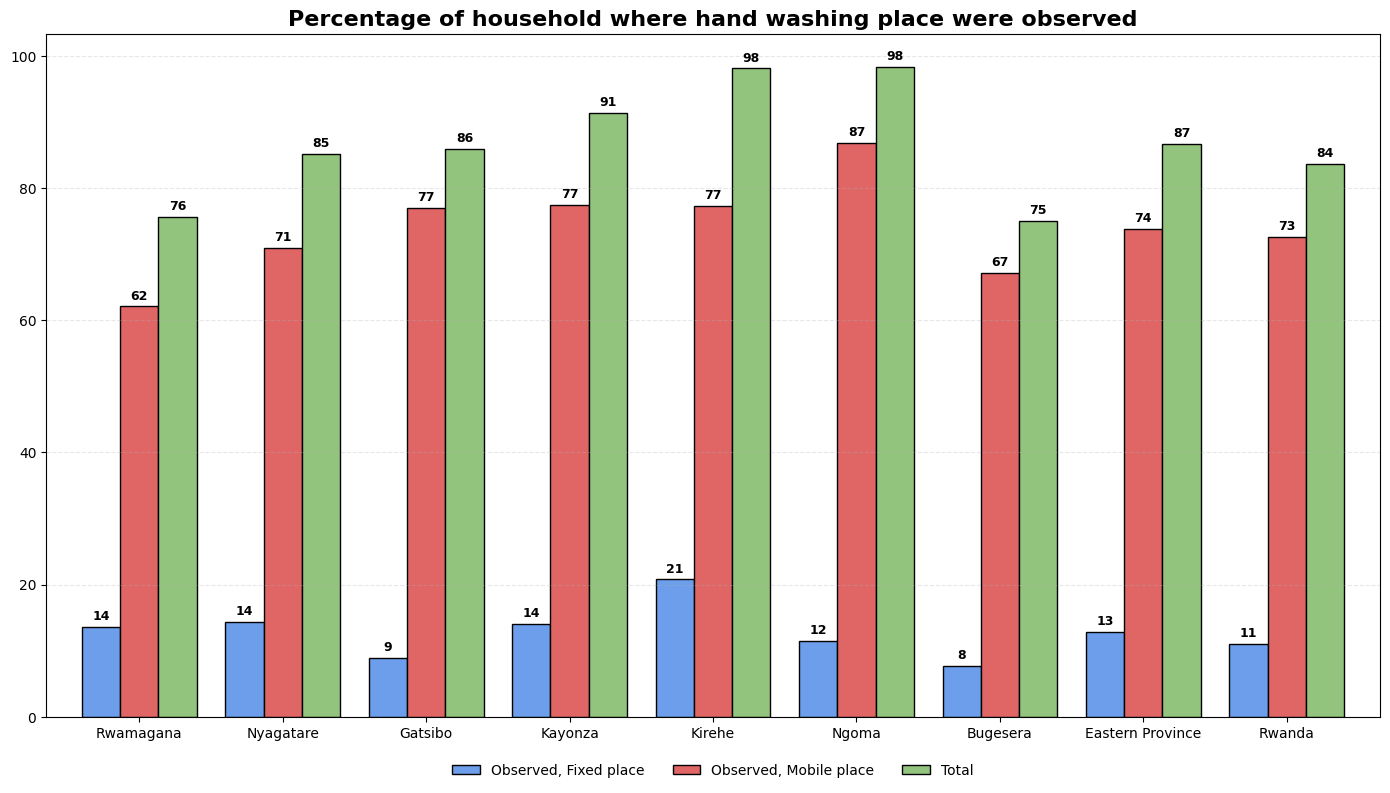

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import os

# --- STEP 1: Load & Global Filter ---
# Load data
df_hr = pd.read_stata("../data/RWHR81FL.DTA", convert_categoricals=False)
df_hr.columns = df_hr.columns.str.lower()

# *** CRITICAL FIX: Filter for COMPLETED Interviews ***
df_hr = df_hr[df_hr['hv015'] == 1].copy()
print(f"Data loaded. Valid households (completed interviews): {len(df_hr)}")

# --- STEP 2: Logic Definition ---

# A. Standard Indicators
binary_vars = {
    'has_electricity': 'hv206',
    'has_mobile': 'hv243a',
    'has_radio': 'hv207',
    'has_tv': 'hv208',
    'has_computer': 'hv243e'
}

for new_col, old_col in binary_vars.items():
    # 1->1, 0->0, 9/Missing -> NaN
    df_hr[new_col] = df_hr[old_col].replace({9: np.nan})

# B. Handwashing Indicators (Figure 3 Logic)
# 1=Fixed, 2=Mobile
df_hr['hw_fixed'] = np.where(df_hr['hv230a'] == 1, 1, 0)
df_hr['hw_mobile'] = np.where(df_hr['hv230a'] == 2, 1, 0)
df_hr['hw_total'] = df_hr['hv230a'].isin([1, 2]).astype(int)

# --- STEP 3: The "Safe" Math Function ---
def get_weighted_pct(df, target_col, weight_col='hv005'):
    # We must ensure the weight column exists before dropping NaNs
    temp = df[[target_col, weight_col]].dropna()
    if len(temp) == 0: return 0
    return np.average(temp[target_col], weights=temp[weight_col]) * 100

# --- STEP 4: Setup EASTERN PROVINCE ---
EASTERN_REGION_CODE = 5
df_hr_eastern = df_hr[df_hr['hv024'] == EASTERN_REGION_CODE].copy()

# The Map for Eastern Districts
district_map = {
    51: 'Rwamagana', 
    52: 'Nyagatare', 
    53: 'Gatsibo',
    54: 'Kayonza',
    55: 'Kirehe',
    56: 'Ngoma',
    57: 'Bugesera'
}

# ==========================================
# PART 1: STANDARD GRAPHS (Electricity etc.)
# ==========================================
indicators = ['has_electricity', 'has_mobile', 'has_radio', 'has_tv', 'has_computer']
titles = {'has_electricity': 'Electricity Access', 'has_mobile': 'Mobile Phone', 
          'has_radio': 'Radio', 'has_tv': 'Television', 'has_computer': 'Computer'}

print("\n--- GENERATING STANDARD INDICATORS (JSON OUTPUT) ---")

for col in indicators:
    # Calculate District
    dist_vals = df_hr_eastern.groupby('shdistrict').apply(lambda x: get_weighted_pct(x, col)).round(1)
    dist_vals.index = dist_vals.index.map(district_map)
    
    # Calculate Province & National
    prov_val = get_weighted_pct(df_hr_eastern, col)
    nat_val = get_weighted_pct(df_hr, col)

    # Combine into one Series
    plot_data = pd.concat([dist_vals, pd.Series([prov_val], index=['Eastern Province']), pd.Series([nat_val], index=['Rwanda'])])

    # --- SAVE TO JSON FILE ---
    # This replaces the CSV output.
    json_filename = f"eastern_{col}.json"
    
    # We convert to a standard dictionary first to ensure clean formatting
    output_dict = {
        "indicator": titles.get(col, col),
        "unit": "Percentage (%)",
        "data": plot_data.to_dict()
    }
    
    # Write to file
    with open(json_filename, "w") as f:
        json.dump(output_dict, f, indent=4)
        
    print(f"Saved: {json_filename}")
    # -------------------------

    # Plot
    plt.figure(figsize=(10, 6))
    colors = ['#6D9EEB'] * len(dist_vals) + ['#93C47D', '#F6B26B'] 
    ax = plot_data.plot(kind='bar', color=colors, edgecolor='white', width=0.6)
    
    # Style
    plt.title(f'{titles.get(col, col)} (%)', fontsize=14, fontweight='bold')
    plt.xticks(rotation=0)
    ax.yaxis.set_visible(False)
    ax.spines['top'].set_visible(False); ax.spines['right'].set_visible(False); ax.spines['left'].set_visible(False)
    
    # Labels
    for p in ax.patches:
        ax.annotate(f'{p.get_height():.0f}', (p.get_x() + p.get_width()/2., p.get_height()), 
                    ha='center', va='bottom', fontsize=11)
    
    plt.tight_layout()
    plt.savefig(f"eastern_Graph_{col}.png")
    plt.close()

# ==========================================
# PART 2: HANDWASHING GRAPH (Figure 3)
# ==========================================
print("\n--- GENERATING HANDWASHING INDICATOR (JSON OUTPUT) ---")

# 1. District Stats
hw_districts = df_hr_eastern.groupby('shdistrict')[['hw_fixed', 'hw_mobile', 'hw_total', 'hv005']].apply(
    lambda x: pd.Series({
        'Observed, Fixed place': get_weighted_pct(x, 'hw_fixed'),
        'Observed, Mobile place': get_weighted_pct(x, 'hw_mobile'),
        'Total': get_weighted_pct(x, 'hw_total')
    })
).round(1)
hw_districts.index = hw_districts.index.map(district_map)

# 2. Province Stats
hw_province = pd.DataFrame([{
    'Observed, Fixed place': get_weighted_pct(df_hr_eastern, 'hw_fixed'),
    'Observed, Mobile place': get_weighted_pct(df_hr_eastern, 'hw_mobile'),
    'Total': get_weighted_pct(df_hr_eastern, 'hw_total')
}], index=['Eastern Province'])

# 3. National Stats
hw_national = pd.DataFrame([{
    'Observed, Fixed place': get_weighted_pct(df_hr, 'hw_fixed'),
    'Observed, Mobile place': get_weighted_pct(df_hr, 'hw_mobile'),
    'Total': get_weighted_pct(df_hr, 'hw_total')
}], index=['Rwanda'])

# 4. Combine
hw_data = pd.concat([hw_districts, hw_province, hw_national])

# --- SAVE TO JSON FILE ---
json_filename_hw = "eastern_Handwashing.json"

output_dict_hw = {
    "indicator": "Handwashing Facilities",
    "unit": "Percentage (%)",
    # orient='index' organizes it by District Name first (e.g. "Rwamagana": {"Total": 45...})
    "data": hw_data.to_dict(orient='index') 
}

with open(json_filename_hw, "w") as f:
    json.dump(output_dict_hw, f, indent=4)

print(f"Saved: {json_filename_hw}")
# -------------------------

# Plot
ax = hw_data.plot(kind='bar', figsize=(14, 8), width=0.8, 
                  color=['#6D9EEB', '#E06666', '#93C47D'], edgecolor='black')

# Style
plt.title('Percentage of household where hand washing place were observed', fontsize=16, fontweight='bold')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=3, frameon=False)

# Labels
for container in ax.containers:
    ax.bar_label(container, fmt='%.0f', padding=3, fontsize=9, fontweight='bold')

plt.tight_layout()
plt.savefig("eastern_Figure3_Handwashing.png")
print("All tasks completed.")